In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re

from scipy.stats import f_oneway,kruskal

In [2]:
plt.rcParams["figure.figsize"] = (15,8)

### Open data

In [3]:
methods=["FA","FP","GS","IG","dCAM","DM","XCM"]
classesmarkers = dict([(methods[i],["o","v","X","d","P","*","s"][i])for i in range(len(methods))])

In [4]:
df_classif = pd.read_csv("classif.csv")
df_restrict_classif_pred =pd.read_csv("restricted_classif_pred.csv")
df_restrict_classif_true = pd.read_csv("restricted_classif_true.csv")
df_expl = pd.read_csv("expl_metrics.csv")

<ipython-input-4-f80475e13a8b>:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_expl = pd.read_csv("expl_metrics.csv")


In [5]:
#I introduce here a very dirty formula to change the wrongly formated string representing a float, that should actually be the str of an int
format_target = lambda x: x if (isinstance(x,str) and re.match(r'^-?\d+(?:\.\d+)$', x) is None) or ((not isinstance(x,str)) and np.isnan(x)) else str(int(float(x)))

df_classif["target"]=df_classif["target"].apply(format_target)
df_expl["target"]=df_expl["target"].apply(format_target)
df_restrict_classif_true["target"]=df_restrict_classif_true["target"].apply(format_target)
df_restrict_classif_pred["target"]=df_restrict_classif_pred["target"].apply(format_target)

In [6]:
df_classif = df_classif[df_classif["roc_auc_score"]>=0.7]

In [7]:
df_expl = df_classif.merge(df_expl,on=["config_name","dataset_name","filename","target","model","explanation"],suffixes=["_orig","_true"])


df_pred = df_classif.merge(df_restrict_classif_pred,
                           on=["config_name","dataset_name","filename","target","model","explanation"],
                           suffixes=["_orig","_pred"])
predcol = ['config_name', 'dataset_name', 'filename', 'target',
       'model','explanation', 'roc_auc_score_orig',
       'roc_auc_score_pred','topKnonlagged',"topKlagged","lagged"]
df_pred = df_pred[[x for x in predcol if x in df_pred.columns]]



df_true = df_classif.merge(df_restrict_classif_true,
                           on=["config_name","dataset_name","filename","target","model"],
                           suffixes=["_orig","_true"])
df_true = df_true[['config_name','dataset_name', 'filename', 'target', "explanation",
       'model', 'roc_auc_score_orig',
       'roc_auc_score_true', "lagged"]]


In [8]:
df_ref = pd.read_csv("reference.csv")

df_classif = df_classif.merge(df_ref,on=["dataset_name","filename","target"])
df_expl = df_expl.merge(df_ref,on=["dataset_name","filename","target"])
df_true = df_true.merge(df_ref,on=["dataset_name","filename","target"])
df_pred = df_pred.merge(df_ref,on=["dataset_name","filename","target"])

In [9]:
#assemble all lagged AUROC in a single dataframe
df_true_lagged = df_true[df_true["lagged"]==True]
df_pred_lagged = df_pred[df_pred["lagged"]==True]

df_true_pred = df_pred_lagged.merge(df_true_lagged[["roc_auc_score_true","dataset_name","filename","target","config_name","explanation","lagged"]],
                                    on=["dataset_name","filename","target","config_name","explanation","lagged"])

In [10]:
df_expl = df_expl.replace(to_replace="SynthNonlin/7ts2h",value="7ts2h")
df_expl = df_expl.replace(to_replace="fMRI_processed_by_Nauta/returns/our_selection",value="fMRI")
df_expl = df_expl.replace(to_replace="TestCLIM_N-5_T-250/returns",value="CLIM")
df_expl = df_expl.replace(to_replace="FinanceCPT/returns/our_selection",value="FINANCE")

df_true_pred = df_true_pred.replace(to_replace="SynthNonlin/7ts2h",value="7ts2h")
df_true_pred = df_true_pred.replace(to_replace="fMRI_processed_by_Nauta/returns/our_selection",value="fMRI")
df_true_pred = df_true_pred.replace(to_replace="TestCLIM_N-5_T-250/returns",value="CLIM")
df_true_pred = df_true_pred.replace(to_replace="FinanceCPT/returns/our_selection",value="FINANCE")

df_expl = df_expl.replace(to_replace="OS",value="FO")
df_expl = df_expl.replace(to_replace="XCM-2D",value="XCM")
df_expl = df_expl.replace(to_replace="XCM_pytorch",value="XCM")
df_true_pred = df_true_pred.replace(to_replace="OS",value="FO")
df_true_pred = df_true_pred.replace(to_replace="XCM-2D",value="XCM")
df_true_pred = df_true_pred.replace(to_replace="XCM_pytorch",value="XCM")

In [11]:
df_true_pred.columns

Index(['config_name', 'dataset_name', 'filename', 'target', 'model',
       'explanation', 'roc_auc_score_orig', 'roc_auc_score_pred', 'topKlagged',
       'lagged', 'num_nonlagged_parents', 'num_lagged_parents',
       'num_nonlagged_ancestors', 'num_lagged_ancestors',
       'num_nonlagged_connected', 'num_lagged_connected',
       'avg_nonlagged_parents', 'avg_lagged_parents',
       'avg_nonlagged_ancestors', 'avg_lagged_ancestors',
       'avg_nonlagged_connected', 'avg_lagged_connected',
       'roc_auc_score_true'],
      dtype='object')

In [12]:
df_true_pred_expl = df_true_pred.merge(
    df_expl[['config_name', 'dataset_name', 'filename', 'target', 'model',
       'explanation', 'topKlagged',"precision@k_mean_lagged"]],
    on=['config_name', 'dataset_name', 'filename', 'target', 'model',
       'explanation', 'topKlagged'])

df_true_pred_expl["EOCOdiff"] = df_true_pred_expl["roc_auc_score_pred"]-df_true_pred_expl["roc_auc_score_true"]

## Classification statistics

In [13]:
d1=df_true_pred.groupby(["model","config_name","dataset_name","explanation"]).count()[["filename"]].rename(columns={"filename":"count"}).reset_index()
d2=df_true_pred.groupby(["model","config_name","dataset_name","explanation"]).mean()[["roc_auc_score_orig"]].rename(columns={"roc_auc_score_orig":"AUCROC"}).reset_index()
d = d1.merge(d2,on=["model","config_name","dataset_name","explanation"])
d = d[d["explanation"]=="FA"][["model","dataset_name","count","AUCROC"]]
d = d.set_index("model")
d["sepl"] = " ("
d["sepr"] = ")"
d["res"] = d["AUCROC"].apply(lambda x:"%.3f"%x)+d["sepl"]+d["count"].apply(int).apply(str)+d["sepr"]
d = d.pivot_table(values='res', index=d.index, columns='dataset_name', aggfunc='first')
print(d.to_latex())

\begin{tabular}{llll}
\toprule
dataset\_name &       7ts2h &         CLIM &        fMRI \\
model       &             &              &             \\
\midrule
LSTM        &  0.912 (52) &  0.775 (115) &  0.807 (49) \\
XCM         &  0.904 (45) &   0.820 (45) &  0.893 (15) \\
dCAM        &  0.858 (38) &   0.776 (61) &  0.799 (25) \\
transformer &  0.899 (50) &   0.784 (26) &  0.915 (16) \\
\bottomrule
\end{tabular}



<ipython-input-13-efbe80534465>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d2=df_true_pred.groupby(["model","config_name","dataset_name","explanation"]).mean()[["roc_auc_score_orig"]].rename(columns={"roc_auc_score_orig":"AUCROC"}).reset_index()
<ipython-input-13-efbe80534465>:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(d.to_latex())


## LAGGED CONSISTENCY AND PRECISION AND RECALL

<ipython-input-14-cf22ae747790>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_method_df=df.groupby(["dataset","filename","target","model","k"]).mean()[["random_precision_mean_lagged"]]
<ipython-input-14-cf22ae747790>:45: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(["dataset","model","explanation","k"]).mean()


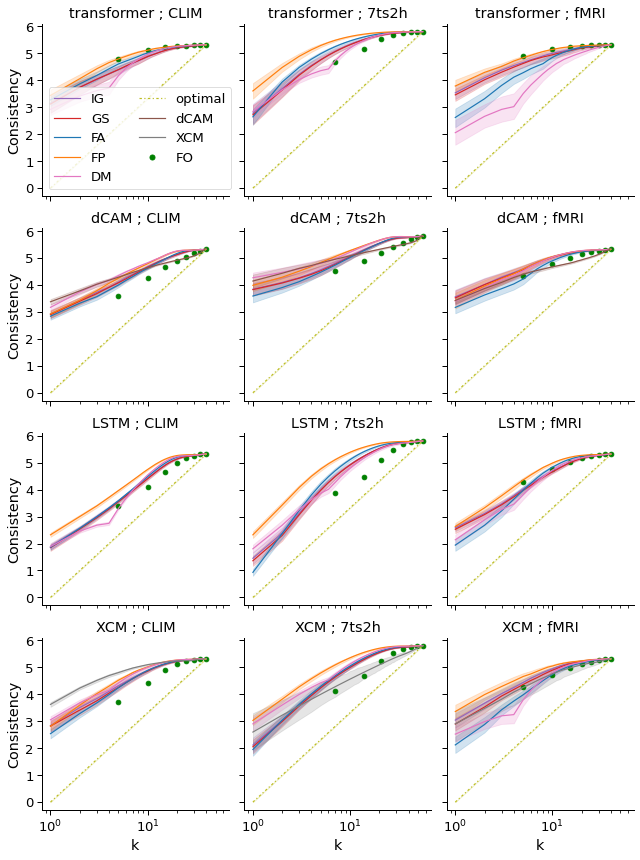

In [14]:
df = df_expl.rename(columns={"dataset_name":"dataset","consistency_lagged_minority":"Consistency","topKlagged":"k"})

df_to_add = df[["dataset","filename","target","model","explanation","Consistency","k"]]
#add the optimal consistency

new_method_df=df.groupby(["dataset","filename","target","model","k"]).mean()[["random_precision_mean_lagged"]]
new_method_df = new_method_df.reset_index()
new_method_df["Consistency"] = np.log2(new_method_df[["k"]])
new_method_df["explanation"]="optimal"
df_to_add = pd.concat((df_to_add,new_method_df))[["dataset","filename","target","model","explanation","Consistency","k"]]
df_to_add = df_to_add.reset_index()

#plot with conventions

methods2=["FA","FP","FO","GS","IG","dCAM","DM","XCM","optimal"]
classescolors2 = dict([(methods2[i],sns.color_palette()[i]) for i in range(len(methods2))])
linestyles = dict([(methods2[i],"" if i<8 else (2,2,1,2)) for i in range(len(methods2))])

#delete FO!
df_to_add = df_to_add[df_to_add["explanation"]!="FO"]

with sns.plotting_context("paper",font_scale=1.5):

    x,y="k","Consistency"
    g = sns.FacetGrid(df_to_add, row="model",col="dataset",legend_out = False)
    g.map_dataframe(sns.lineplot, x, y, hue="explanation",style="explanation",palette=classescolors2,dashes=linestyles)
    
    g.set_titles("{row_name} ; {col_name}")
    
    g.set(xscale='log')
    g.add_legend()


    g.legend.texts.append(matplotlib.text.Text(0, 0, 'FO'))
    g.legend.legendHandles.append(matplotlib.lines.Line2D([0], [0], marker='o', color='g', label='FO',
                                                          markerfacecolor='g', markersize=5, linestyle="none"))

    g.legend.axes.legend(handles=g.legend.legendHandles,ncols=2)


    #FO processing
    df = df_expl.rename(columns={"dataset_name":"dataset","consistency_lagged_minority":"Consistency","topKlagged":"k"})
    df = df[["dataset","filename","target","model","explanation","Consistency","k"]]
    df = df[df["explanation"] == "FO"]
    df = df.groupby(["dataset","model","explanation","k"]).mean()
    df = df.reset_index()
    #select only the right topK
    df1 = df[df["dataset"]=="7ts2h"]
    df1 = df1[df1["k"].isin(list(range(0,7*8+1,7)))]
    df2 = df[df["dataset"]!="7ts2h"]
    df2 = df2[df2["k"].isin(list(range(0,5*8+1,5)))]
    df = pd.concat((df1,df2))
    #print(df)

    datasetorder=["CLIM","7ts2h","fMRI"]
    modelorder=["transformer","dCAM","LSTM","XCM"]

    for i,axlist in enumerate(g.axes):
        for j,ax in enumerate(axlist):
            data=df[df["model"]==modelorder[i]]
            data=data[data["dataset"]==datasetorder[j]]
            #print(data)
            ax.scatter(data["k"],data["Consistency"],c="g")


    g.savefig("temp.svg")

<ipython-input-15-735547926da7>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_method_df=df.groupby(["dataset","filename","target","model","k"]).mean()[["random_precision_mean_lagged"]]
<ipython-input-15-735547926da7>:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_method_df=df.groupby(["dataset","filename","target","model","k"]).mean()[["num_lagged_parents"]]
<ipython-input-15-735547926da7>:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which 

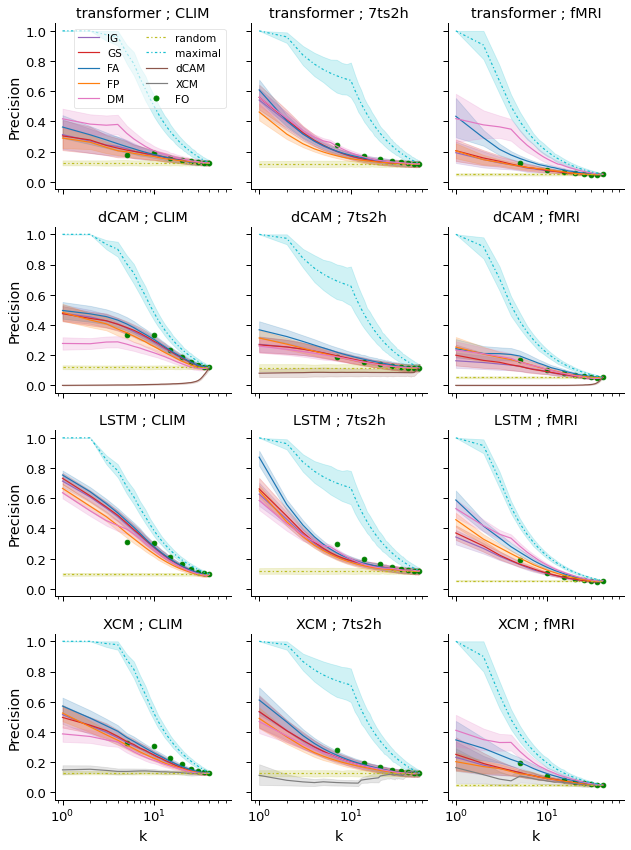

In [15]:
df = df_expl.rename(columns={"dataset_name":"dataset","consistency_lagged_minority":"Consistency","topKlagged":"k"})
df = df.rename(columns={"precision@k_mean_lagged":"Precision"})

df_to_add = df[["dataset","filename","target","model","explanation","Precision","k"]]
#add the random precision

new_method_df=df.groupby(["dataset","filename","target","model","k"]).mean()[["random_precision_mean_lagged"]]
new_method_df = new_method_df.rename(columns={"random_precision_mean_lagged":"Precision"})
new_method_df = new_method_df.reset_index()
new_method_df["explanation"]="random"
df_to_add = pd.concat((df_to_add,new_method_df))[["dataset","filename","target","model","explanation","Precision","k"]]
df_to_add = df_to_add.reset_index()

#add maximal precision

new_method_df=df.groupby(["dataset","filename","target","model","k"]).mean()[["num_lagged_parents"]]
new_method_df = new_method_df.rename(columns={"num_lagged_parents":"Precision"})
new_method_df = new_method_df.reset_index()
new_method_df["Precision"] = new_method_df["Precision"]/new_method_df["k"]
new_method_df["Precision"] = new_method_df["Precision"].apply(lambda x:min(1.,x))
new_method_df["explanation"]="maximal"
df_to_add = pd.concat((df_to_add,new_method_df))[["dataset","filename","target","model","explanation","Precision","k"]]
df_to_add = df_to_add.reset_index()

#delete FO!
df_to_add = df_to_add[df_to_add["explanation"]!="FO"]

with sns.plotting_context("paper",font_scale=1.5):
    #plot with conventions

    methods2=["FA","FP","FO","GS","IG","dCAM","DM","XCM","random","maximal"]
    classescolors2 = dict([(methods2[i],sns.color_palette()[i]) for i in range(len(methods2))])
    linestyles = dict([(methods2[i],"" if i<8 else (2,2,1,2)) for i in range(len(methods2))])


    x,y="k","Precision"
    g = sns.FacetGrid(df_to_add, row="model",col="dataset",legend_out = False)
    g.map_dataframe(sns.lineplot, x, y, hue="explanation",style="explanation",palette=classescolors2,dashes=linestyles)
    g.add_legend()

    g.set_titles("{row_name} ; {col_name}")
    
    g.set(xscale='log')



with sns.plotting_context("paper",font_scale=1.2):
    g.legend.texts.append(matplotlib.text.Text(0, 0, 'FO'))
    g.legend.legendHandles.append(matplotlib.lines.Line2D([0], [0], marker='o', color='g', label='FO',
                                                          markerfacecolor='g', markersize=5, linestyle="none"))


    g.legend.axes.legend(handles=g.legend.legendHandles,ncols=2,framealpha=0.6)


    #FO processing
    df = df_expl.rename(columns={"dataset_name":"dataset","consistency_lagged_minority":"Consistency","topKlagged":"k"})
    df = df.rename(columns={"precision@k_mean_lagged":"Precision"})
    df = df[["dataset","filename","target","model","explanation","Precision","k"]]
    df = df[df["explanation"] == "FO"]
    df = df.groupby(["dataset","model","explanation","k"]).mean()
    df = df.reset_index()
    #select only the right topK
    df1 = df[df["dataset"]=="7ts2h"]
    df1 = df1[df1["k"].isin(list(range(0,7*8+1,7)))]
    df2 = df[df["dataset"]!="7ts2h"]
    df2 = df2[df2["k"].isin(list(range(0,5*8+1,5)))]
    df = pd.concat((df1,df2))
    #print(df)

    datasetorder=["CLIM","7ts2h","fMRI"]
    modelorder=["transformer","dCAM","LSTM","XCM"]

    for i,axlist in enumerate(g.axes):
        for j,ax in enumerate(axlist):
            data=df[df["model"]==modelorder[i]]
            data=data[data["dataset"]==datasetorder[j]]
            #print(data)
            ax.scatter(data["k"],data["Precision"],c="g")



    g.savefig("temp.svg")

<ipython-input-16-0906249f69df>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_method_df=df.groupby(["dataset","filename","target","model","k"]).mean()[["random_recall_mean_lagged"]]
<ipython-input-16-0906249f69df>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_method_df=df.groupby(["dataset","filename","target","model","k"]).mean()[["num_lagged_parents"]]
<ipython-input-16-0906249f69df>:62: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which sho

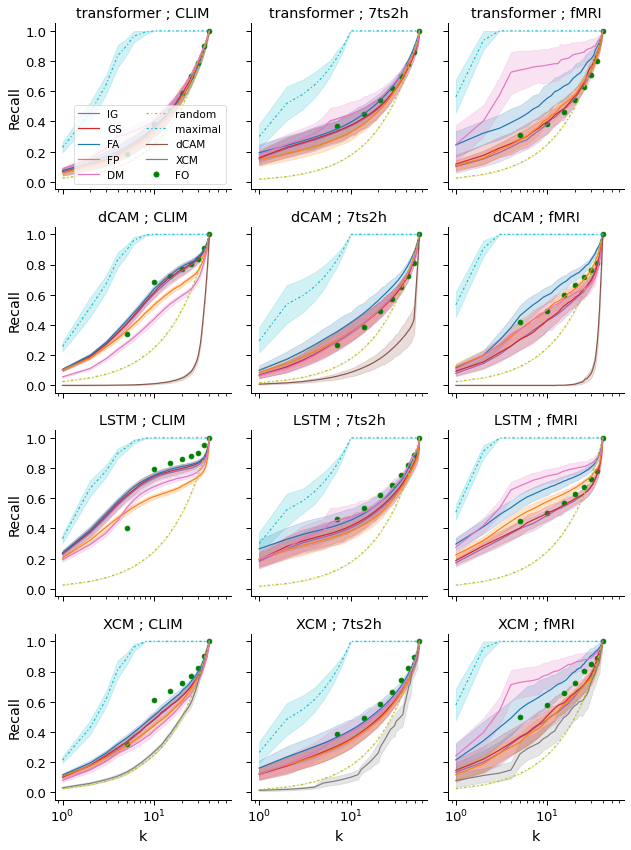

In [16]:
df = df_expl.rename(columns={"dataset_name":"dataset","consistency_lagged_minority":"Consistency","topKlagged":"k"})
df = df.rename(columns={"precision@k_mean_lagged":"Precision"})

df = df.rename(columns={"recall@k_mean_lagged":"Recall"})

df_to_add = df[["dataset","filename","target","model","explanation","Recall","k"]]
#add the random recall

new_method_df=df.groupby(["dataset","filename","target","model","k"]).mean()[["random_recall_mean_lagged"]]
new_method_df = new_method_df.rename(columns={"random_recall_mean_lagged":"Recall"})
new_method_df = new_method_df.reset_index()
new_method_df["explanation"]="random"
df_to_add = pd.concat((df_to_add,new_method_df))[["dataset","filename","target","model","explanation","Recall","k"]]
df_to_add = df_to_add.reset_index()

#add maximal recall

new_method_df=df.groupby(["dataset","filename","target","model","k"]).mean()[["num_lagged_parents"]]
new_method_df = new_method_df.rename(columns={"num_lagged_parents":"Recall"})
new_method_df = new_method_df.reset_index()
new_method_df["Recall"] = new_method_df["k"]/new_method_df["Recall"]
new_method_df["Recall"] = new_method_df["Recall"].apply(lambda x:min(1.,x))
new_method_df["explanation"]="maximal"
df_to_add = pd.concat((df_to_add,new_method_df))[["dataset","filename","target","model","explanation","Recall","k"]]
df_to_add = df_to_add.reset_index()

#delete FO!
df_to_add = df_to_add[df_to_add["explanation"]!="FO"]

with sns.plotting_context("paper",font_scale=1.5):
    #plot with conventions

    methods2=["FA","FP","FO","GS","IG","dCAM","DM","XCM","random","maximal"]
    classescolors2 = dict([(methods2[i],sns.color_palette()[i]) for i in range(len(methods2))])
    linestyles = dict([(methods2[i],"" if i<8 else (2,2,1,2)) for i in range(len(methods2))])


    x,y="k","Recall"
    g = sns.FacetGrid(df_to_add, row="model",col="dataset",legend_out = False)
    g.map_dataframe(sns.lineplot, x, y, hue="explanation",style="explanation",palette=classescolors2,dashes=linestyles)
    g.add_legend()
    
    g.set_titles("{row_name} ; {col_name}")

    g.set(xscale='log')



with sns.plotting_context("paper",font_scale=1.2):
    g.legend.texts.append(matplotlib.text.Text(0, 0, 'FO'))
    g.legend.legendHandles.append(matplotlib.lines.Line2D([0], [0], marker='o', color='g', label='FO',
                                                          markerfacecolor='g', markersize=5, linestyle="none"))

    g.legend.axes.legend(handles=g.legend.legendHandles,ncols=2)


    #FO processing
    df = df_expl.rename(columns={"dataset_name":"dataset","consistency_lagged_minority":"Consistency","topKlagged":"k"})
    df = df.rename(columns={"recall@k_mean_lagged":"Recall"})
    df = df[["dataset","filename","target","model","explanation","Recall","k"]]
    df = df[df["explanation"] == "FO"]
    df = df.groupby(["dataset","model","explanation","k"]).mean()
    df = df.reset_index()
    #select only the right topK
    df1 = df[df["dataset"]=="7ts2h"]
    df1 = df1[df1["k"].isin(list(range(0,7*8+1,7)))]
    df2 = df[df["dataset"]!="7ts2h"]
    df2 = df2[df2["k"].isin(list(range(0,5*8+1,5)))]
    df = pd.concat((df1,df2))
    #print(df)

    datasetorder=["CLIM","7ts2h","fMRI"]
    modelorder=["transformer","dCAM","LSTM","XCM"]

    for i,axlist in enumerate(g.axes):
        for j,ax in enumerate(axlist):
            data=df[df["model"]==modelorder[i]]
            data=data[data["dataset"]==datasetorder[j]]
            #print(data)
            ax.scatter(data["k"],data["Recall"],c="g")


    g.savefig("temp.svg")

# Corrected AUROC graphs to compare true and pred perf

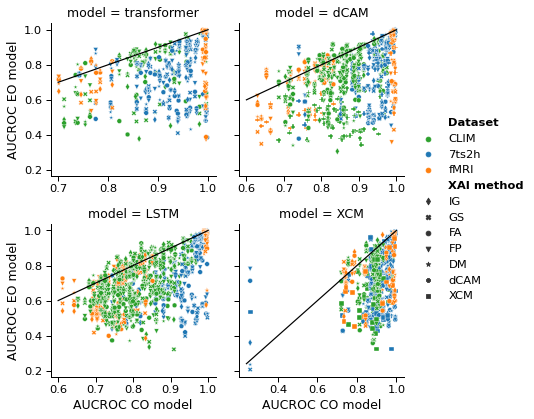

In [18]:
df = df_true_pred_expl#[df_true_pred["explanation"].isin(["GS","IG"])]

#delete FO!
df = df[df["explanation"]!="FO"]

with sns.plotting_context("paper",font_scale=1.3):

    g = sns.FacetGrid(df, col="model",col_wrap=2,legend_out = True, sharex=False)

    g.map_dataframe(sns.scatterplot, x="roc_auc_score_true", y="roc_auc_score_pred",
                    hue="dataset_name",style="explanation",
                    palette = {"7ts2h":sns.color_palette()[0],"fMRI":sns.color_palette()[1],"CLIM":sns.color_palette()[2]},
                    markers = classesmarkers)

    g.add_legend()

    t = g._legend.get_texts()
    t[0].set_text("Dataset")
    t[0].set_weight("bold")
    if len(t)>3:t[4].set_text("XAI method")
    if len(t)>3:t[4].set_weight("bold")

    #t[1].set_text("7ts2h")
    #t[2].set_text("fMRI")
    #t[3].set_text("CLIM")

    #t[11].set_text("FINANCE")

    g._axes[2].set_xlabel("AUCROC CO model")
    g._axes[3].set_xlabel("AUCROC CO model")
    #g._axes[0][2].set_xlabel("AUCROC CO model")
    g._axes[0].set_ylabel("AUCROC EO model")
    g._axes[2].set_ylabel("AUCROC EO model")

    g._axes[0].plot([0.7,1],[0.7,1],color="black")
    g._axes[1].plot([0.6,1],[0.6,1],color="black")
    g._axes[2].plot([0.6,1],[0.6,1],color="black")
    _=g._axes[3].plot([0.24,1],[0.24,1],color="black")
g.savefig("try.svg")

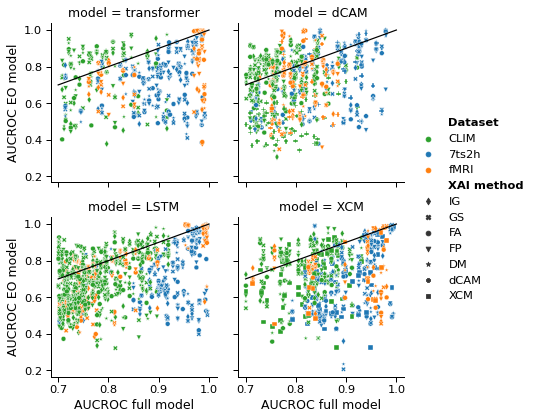

In [20]:
df = df_true_pred_expl#[df_true_pred["explanation"].isin(["GS","IG"])]

#delete FO!
df = df[df["explanation"]!="FO"]


with sns.plotting_context("paper",font_scale=1.3):

    g = sns.FacetGrid(df, col="model",col_wrap=2,legend_out = True)

    g.map_dataframe(sns.scatterplot, x="roc_auc_score_orig", y="roc_auc_score_pred",
                    hue="dataset_name", style="explanation",
                    palette = {"7ts2h":sns.color_palette()[0],"fMRI":sns.color_palette()[1],"CLIM":sns.color_palette()[2]},
                    markers = classesmarkers)
    g.add_legend()

    t = g._legend.get_texts()
    t[0].set_text("Dataset")
    t[0].set_weight("bold")
    if len(t)>3:t[4].set_text("XAI method")
    if len(t)>3:t[4].set_weight("bold")

    #t[1].set_text("7ts2h")
    #t[2].set_text("fMRI")
    #t[3].set_text("CLIM")

    #t[11].set_text("FINANCE")

    g._axes[2].set_xlabel("AUCROC full model")
    g._axes[3].set_xlabel("AUCROC full model")
    #g._axes[0][2].set_xlabel("AUCROC CO model")
    g._axes[0].set_ylabel("AUCROC EO model")
    g._axes[2].set_ylabel("AUCROC EO model")

    g._axes[0].plot([0.7,1],[0.7,1],color="black")
    g._axes[1].plot([0.7,1],[0.7,1],color="black")
    g._axes[2].plot([0.7,1],[0.7,1],color="black")
    _=g._axes[3].plot([0.7,1],[0.7,1],color="black")
    g.savefig("try.svg")

In [21]:
df_true_pred_expl[df_true_pred_expl["roc_auc_score_true"]<=0.5]

,config_name,dataset_name,filename,target,model,explanation,roc_auc_score_orig,roc_auc_score_pred,topKlagged,lagged,...,num_lagged_connected,avg_nonlagged_parents,avg_lagged_parents,avg_nonlagged_ancestors,avg_lagged_ancestors,avg_nonlagged_connected,avg_lagged_connected,roc_auc_score_true,precision@k_mean_lagged,EOCOdiff
1175,xcm_7ts2h_2,7ts2h,data_5.csv,D,XCM,IG,0.894784,0.360251,10,True,...,63,2.428571,6.428571,3.714286,34.571429,7.0,63.0,0.258842,0.203141,0.101409
1176,xcm_7ts2h_2,7ts2h,data_5.csv,D,XCM,GS,0.894784,0.206607,10,True,...,63,2.428571,6.428571,3.714286,34.571429,7.0,63.0,0.258842,0.197906,-0.052235
1177,xcm_7ts2h_2,7ts2h,data_5.csv,D,XCM,FA,0.894784,0.712948,10,True,...,63,2.428571,6.428571,3.714286,34.571429,7.0,63.0,0.258842,0.184555,0.454106
1178,xcm_7ts2h_2,7ts2h,data_5.csv,D,XCM,FP,0.894784,0.781025,10,True,...,63,2.428571,6.428571,3.714286,34.571429,7.0,63.0,0.258842,0.220157,0.522183
1179,xcm_7ts2h_2,7ts2h,data_5.csv,D,XCM,FO,0.894784,0.716843,10,True,...,63,2.428571,6.428571,3.714286,34.571429,7.0,63.0,0.258842,0.224084,0.458001
1180,xcm_7ts2h_2,7ts2h,data_5.csv,D,XCM,DM,0.894784,0.235112,10,True,...,63,2.428571,6.428571,3.714286,34.571429,7.0,63.0,0.258842,0.223298,-0.023730
1181,xcm_7ts2h_2,7ts2h,data_5.csv,D,XCM,XCM,0.894784,0.535276,10,True,...,63,2.428571,6.428571,3.714286,34.571429,7.0,63.0,0.258842,0.000000,0.276434
